In [161]:
import random

from math import exp

import numpy as np
from enum import Enum

Methods = Enum('Methods', ['Classic', 'Momentum', 'AdaGrad', 'RMSprop', 'Adam', 'Nesterov'])
Regularization = Enum('Regularization', ['WithoutRegularization', 'L1', 'L2', 'Elastic'])
LearningRate = Enum('LearningRate', ['Const'])
LearningRateScheduling = Enum('LearningRateScheduling', ['Classic', 'Stepwise', 'Exponential'])


def sign(x):
    if x > 0:
        return 1
    elif x == 0:
        return 0
    else:
        return -1


class LinearRegression:
    def __init__(self, T, W, X, Y, regularization=Regularization.WithoutRegularization, l1=0.1, l2=0.1):
        self.T = np.array([T[i % len(T)](X[i // len(T)]) for i in range(len(T) * len(X))]).reshape(len(X), len(T))
        self.W = W
        self.X = X
        self.Y = Y
        self.regularization = regularization
        self.l1 = l1
        self.l2 = l2
        self.W_points = [np.copy(self.W)]
        self.loss_values = [self.loss(self.W)]

    def loss(self, W_Arg, is_avarage=False):
        val = sum([(np.dot(self.T[i], W_Arg) - self.Y[i]) ** 2 for i in range(len(self.X))])
        match self.regularization:
            case Regularization.L1:
                val += self.l1 * sum([abs(w) for w in self.W])
            case Regularization.L2:
                val += self.l2 * sum([w ** 2 for w in self.W])
            case Regularization.Elastic:
                val += (self.l1 * sum([abs(w) for w in self.W])) + (self.l2 * sum([w ** 2 for w in self.W]))

        return val / len(self.X) if is_avarage else val

    def grad_by_components(self, index_components, W_Arg):
        grad_with_batch = np.zeros(len(W_Arg))
        for i in index_components:
            grad_with_batch += (2 * (np.dot(self.T[i], W_Arg) - self.Y[i]) * self.T[i])
        match self.regularization:
            case Regularization.L1:
                grad_with_batch += self.l1 * np.array([sign(w) for w in self.W])
            case Regularization.L2:
                grad_with_batch += self.l2 * 2 * self.W
            case Regularization.Elastic:
                grad_with_batch += (self.l1 * np.array([sign(w) for w in self.W])) + (self.l2 * 2 * self.W)

        return grad_with_batch

    def analytical_solution(self):
        return (np.linalg.inv(np.transpose(self.T) @ self.T) @ np.transpose(self.T)) @ self.Y


def sgd(lin_reg, lr, lrs, batch, max_num_of_step, beta_1, beta_2, eps_adam, is_corr_beta_1=True,
        is_corr_beta_2=True, is_nesterov=False, is_adagrad=False, store_points=False):
    i = 0
    V = np.zeros(len(lin_reg.W))
    S = np.zeros(len(lin_reg.W))
    lrs_func = lrs_handler(lrs)
    while True:
        i += 1

        components = [(i * batch + j) % len(lin_reg.X) for j in range(batch)]
        cur_w = lin_reg.W
        grad_with_batch = lin_reg.grad_by_components(components, cur_w)

        alpha = lrs_func(lr(lambda a: lin_reg.loss(lin_reg.W - a * grad_with_batch)), (i * batch) // len(lin_reg.X))
        if is_nesterov:
            cur_w -= alpha * beta_1 * V
            grad_with_batch = lin_reg.grad_by_components(components, cur_w)

        V = (beta_1 * V) + (1 - beta_1) * grad_with_batch
        S = (beta_2 * S) + (1 - beta_2) * (grad_with_batch ** 2) if ~is_adagrad else (S + grad_with_batch ** 2)
        V_norm = V / (1 - (beta_1 ** (i + 1))) if is_corr_beta_1 else V
        S_norm = S / (1 - (beta_2 ** (i + 1))) if is_corr_beta_2 else S

        lin_reg.W = lin_reg.W - alpha * (V_norm / ((S_norm + eps_adam) ** 0.5))

        loss_W = lin_reg.loss(lin_reg.W)
        if store_points:
            lin_reg.W_points.append(np.copy(lin_reg.W))
        lin_reg.loss_values.append(loss_W)
        if i >= max_num_of_step:
            break

    return i


def sgd_handler(lin_reg, lr, method, lrs=LearningRateScheduling.Classic, batch=1, beta_1=0.9, beta_2=0.999,
                eps_adam=10 ** -8, max_num_of_step=2500, store_points=False):
    match method:
        case Methods.Classic:
            return sgd(lin_reg, lr, lrs, batch, max_num_of_step, beta_1=0., beta_2=1., eps_adam=1,
                       is_corr_beta_1=False, is_corr_beta_2=False, store_points=store_points)
        case Methods.Momentum:
            return sgd(lin_reg, lr, lrs, batch, max_num_of_step, beta_1, beta_2=1., eps_adam=1,
                       is_corr_beta_1=False, is_corr_beta_2=False, store_points=store_points)
        case Methods.AdaGrad:
            return sgd(lin_reg, lr, lrs, batch, max_num_of_step, beta_1=0., beta_2=0.5, eps_adam=eps_adam,
                       is_corr_beta_1=False, is_corr_beta_2=False, is_adagrad=True, store_points=store_points)
        case Methods.RMSprop:
            return sgd(lin_reg, lr, lrs, batch, max_num_of_step, beta_1=0., beta_2=beta_2, eps_adam=eps_adam,
                       is_corr_beta_1=False, store_points=store_points)
        case Methods.Adam:
            return sgd(lin_reg, lr, lrs, batch, max_num_of_step, beta_1, beta_2, eps_adam,
                       store_points=store_points)
        case Methods.Nesterov:
            return sgd(lin_reg, lr, lrs, batch, max_num_of_step, beta_1, beta_2=1., eps_adam=1,
                       is_corr_beta_1=False, is_corr_beta_2=False, is_nesterov=True, store_points=store_points)


def lrs_exp(decay):
    return lambda lr, epoch: max(0.0001, lr * exp(-decay * epoch))


def lrs_step(decay, epoch_update):
    return lambda lr, epoch: max(0.0001, lr * (decay ** (epoch // epoch_update)))


def lrs_handler(lrs, epoch_update=10):
    match lrs:
        case LearningRateScheduling.Classic:
            return lambda lr, epoch: lr
        case LearningRateScheduling.Stepwise:
            return lrs_step(0.75, epoch_update)
        case LearningRateScheduling.Exponential:
            return lrs_exp(0.05)



In [162]:
import matplotlib.pyplot as plt


def visualise_points(lin_reg, need_analys_solve=True):
    x = np.linspace(min(lin_reg.X), max(lin_reg.X), 1000)
    y = sum([lin_reg.W[i] * (x ** i) for i in range(len(lin_reg.W))])
    plt.plot(x, y, '-r')
    if need_analys_solve:
        analys_w = lin_reg.analytical_solution()
        analys_y = sum([analys_w[i] * (x ** i) for i in range(len(analys_w))])
        plt.plot(x, analys_y, '-b')
    plt.plot(lin_reg.X, lin_reg.Y, 'og', linestyle='None')
    plt.legend(['Analytics solution', 'Predict solution', 'Train data'])
    plt.xlabel("x")
    plt.show()


def visualise_linear_sgd(lin_reg):
    values = [[], []]
    for i in range(len(lin_reg.W_points)):
        values[0].append(lin_reg.W_points[i][0])
        values[1].append(lin_reg.W_points[i][1])
    print(values[0][0], values[1][0])
    X = np.linspace(min(values[0]) - 20, max(values[0]) + 20, 100)
    Y = np.linspace(min(values[1]) - 20, max(values[1]) + 20, 100)
    Z = [[lin_reg.loss(np.array([X[i], Y[j]])) for i in range(len(X))] for j in range(len(Y))]
    plt.contour(X, Y, Z, 50)

    plt.plot(values[0], values[1], marker='.')
    plt.plot(values[0][0], values[1][0], 'og')
    plt.plot(values[0][-1], values[1][-1], 'or')
    plt.legend(['SGD', 'Start point', 'End point'])
    plt.xlabel('w_1')
    plt.ylabel('w_2')
    plt.show()


def visualise_batch_res(batch_res):
    fig, ax = plt.subplots()
    x = [i + 1 for i in range(len(batch_res) - 1)]
    y = batch_res[1:]
    ax.plot(x, y)
    ax.set_xticks(np.arange(1, len(batch_res), 10))
    ax.set_xlabel('Batch size')
    ax.set_ylabel('Relative error')
    plt.show()




--------------------------------------------------
Regul Test


C:\Users\vryab\AppData\Local\Temp\ipykernel_2632\3239883097.py:84: RuntimeWarning: overflow encountered in square
  S = (beta_2 * S) + (1 - beta_2) * (grad_with_batch ** 2) if ~is_adagrad else (S + grad_with_batch ** 2)
C:\Users\vryab\AppData\Local\Temp\ipykernel_2632\3239883097.py:84: RuntimeWarning: invalid value encountered in multiply
  S = (beta_2 * S) + (1 - beta_2) * (grad_with_batch ** 2) if ~is_adagrad else (S + grad_with_batch ** 2)


Method: Classic | LR : 0.01, LRS: Classic, Batch: 1 | Steps: 2500, Time (sec): 0.4450194835662842, Error: nan | Mem: (235773, 237237)
Regularization: WithoutRegularization


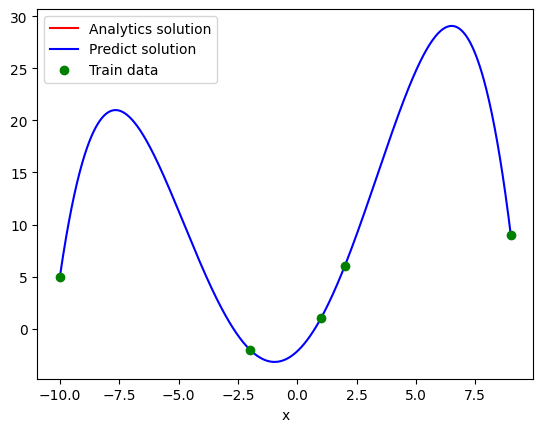

Method: Classic | LR : 0.01, LRS: Classic, Batch: 5 | Steps: 2500, Time (sec): 0.7180309295654297, Error: nan | Mem: (228227, 229723)
Regularization: WithoutRegularization


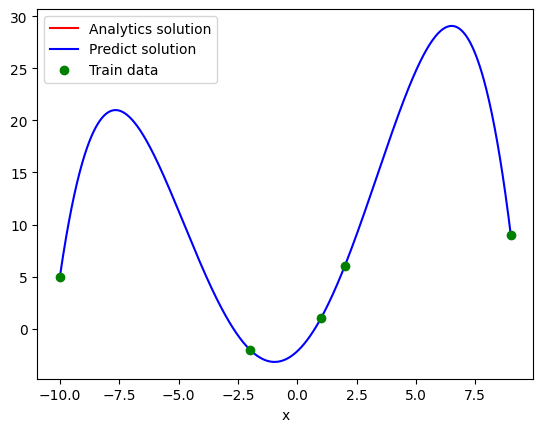

Method: Classic | LR : 0.01, LRS: Stepwise, Batch: 1 | Steps: 2500, Time (sec): 0.6230018138885498, Error: nan | Mem: (228270, 229814)
Regularization: WithoutRegularization


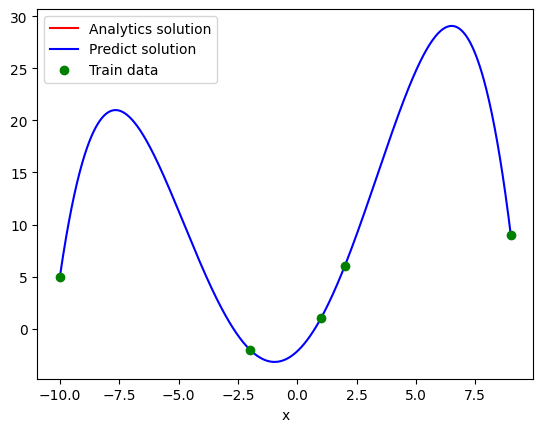

Method: Classic | LR : 0.01, LRS: Stepwise, Batch: 5 | Steps: 2500, Time (sec): 0.7669703960418701, Error: nan | Mem: (228450, 230026)
Regularization: WithoutRegularization


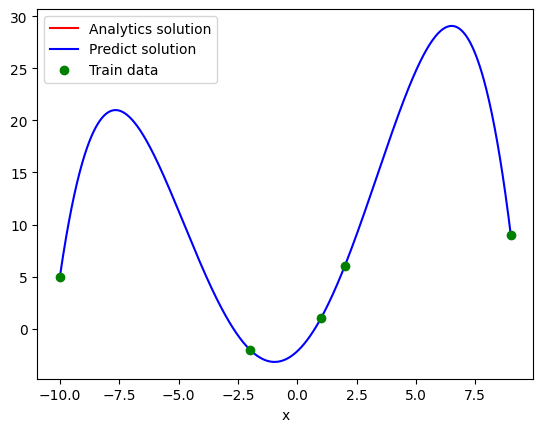

Method: Momentum | LR : 0.01, LRS: Classic, Batch: 1 | Steps: 2500, Time (sec): 0.40799808502197266, Error: nan | Mem: (228227, 229691)
Regularization: WithoutRegularization


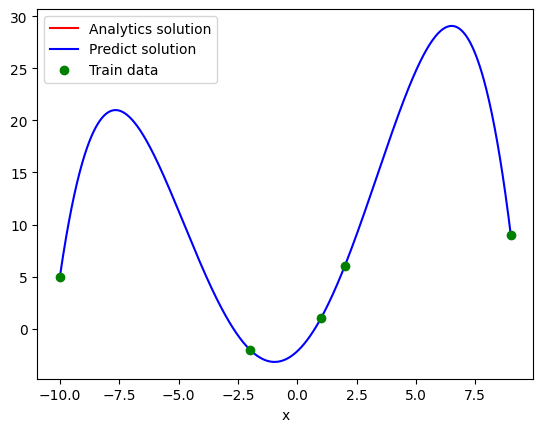

Method: Momentum | LR : 0.01, LRS: Classic, Batch: 5 | Steps: 2500, Time (sec): 0.6530263423919678, Error: nan | Mem: (228337, 229833)
Regularization: WithoutRegularization


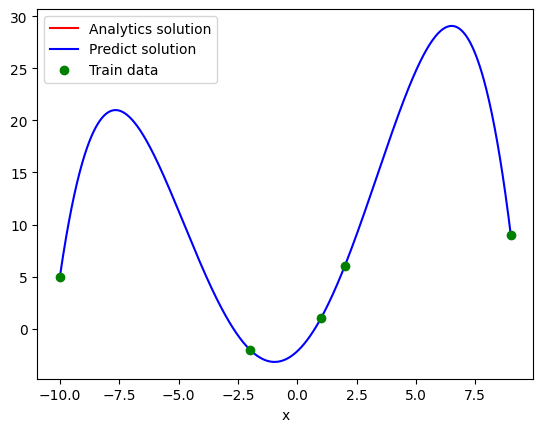

Method: Momentum | LR : 0.01, LRS: Stepwise, Batch: 1 | Steps: 2500, Time (sec): 0.4430255889892578, Error: nan | Mem: (228227, 229771)
Regularization: WithoutRegularization


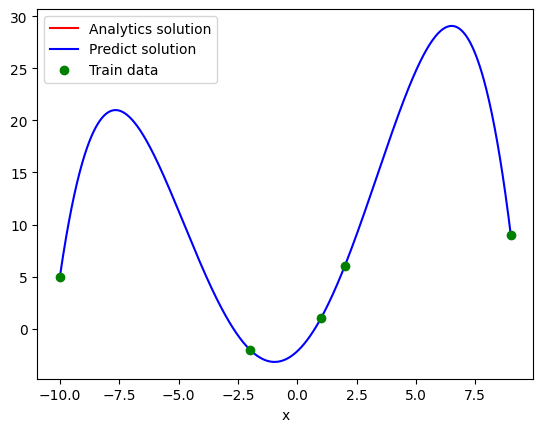

Method: Momentum | LR : 0.01, LRS: Stepwise, Batch: 5 | Steps: 2500, Time (sec): 0.5589959621429443, Error: nan | Mem: (228450, 230026)
Regularization: WithoutRegularization


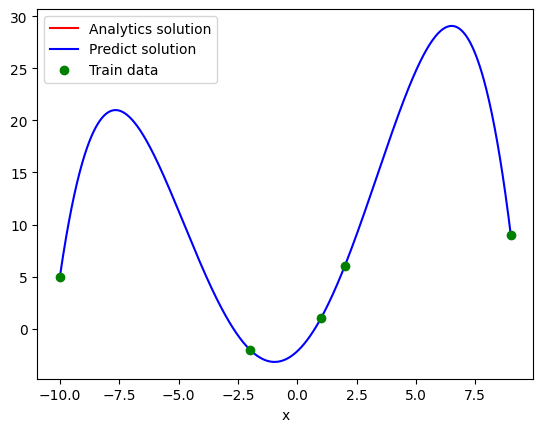

Method: AdaGrad | LR : 0.01, LRS: Classic, Batch: 1 | Steps: 2500, Time (sec): 0.3000185489654541, Error: 15079.087373871911 | Mem: (228227, 229691)
Regularization: WithoutRegularization


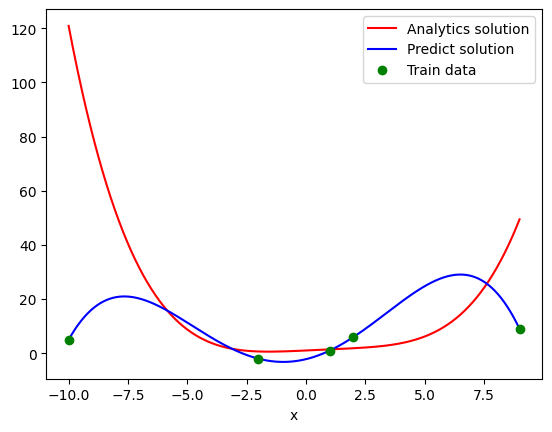

Method: AdaGrad | LR : 0.01, LRS: Classic, Batch: 5 | Steps: 2500, Time (sec): 0.39800143241882324, Error: 3994.5300048172703 | Mem: (228371, 229867)
Regularization: WithoutRegularization


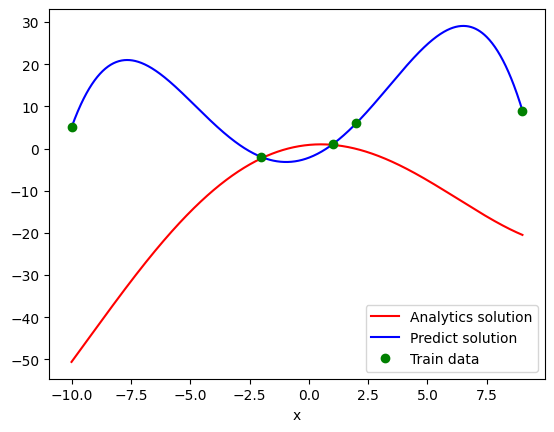

Method: AdaGrad | LR : 0.01, LRS: Stepwise, Batch: 1 | Steps: 2500, Time (sec): 0.26599574089050293, Error: 971414.9378013257 | Mem: (228227, 229771)
Regularization: WithoutRegularization


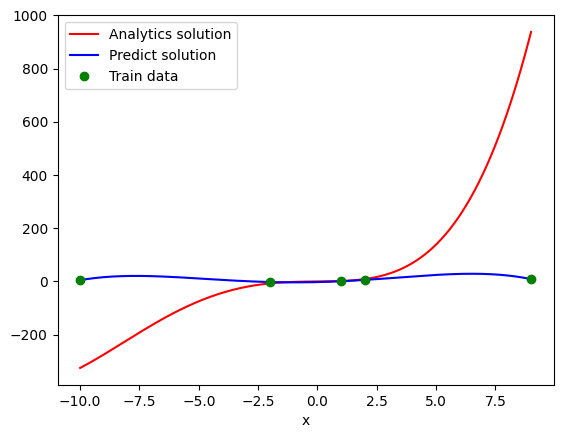

Method: AdaGrad | LR : 0.01, LRS: Stepwise, Batch: 5 | Steps: 2500, Time (sec): 0.37200069427490234, Error: 18053278.53854806 | Mem: (228227, 229803)
Regularization: WithoutRegularization


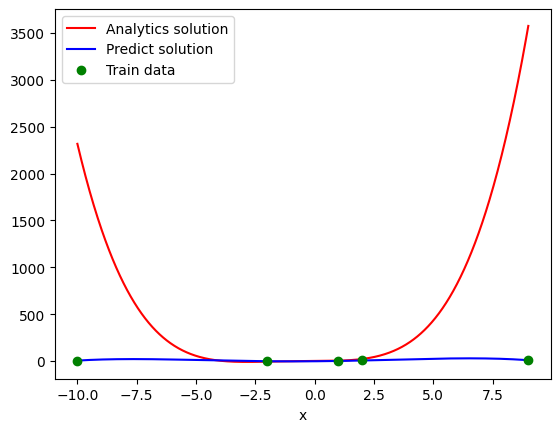

Method: RMSprop | LR : 0.01, LRS: Classic, Batch: 1 | Steps: 2500, Time (sec): 0.27599644660949707, Error: 52.45423056342166 | Mem: (80660, 82260)
Regularization: WithoutRegularization


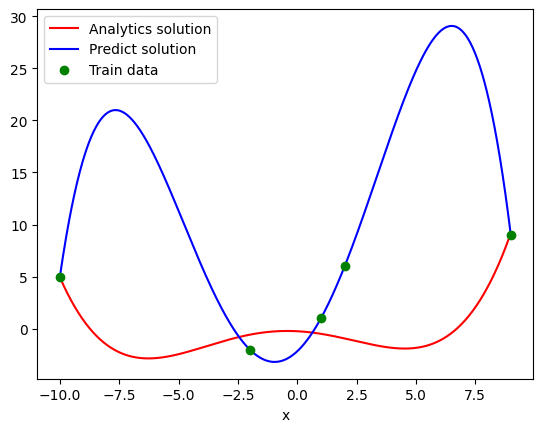

Method: RMSprop | LR : 0.01, LRS: Classic, Batch: 5 | Steps: 2500, Time (sec): 0.37700390815734863, Error: 74.66040231216465 | Mem: (228243, 229875)
Regularization: WithoutRegularization


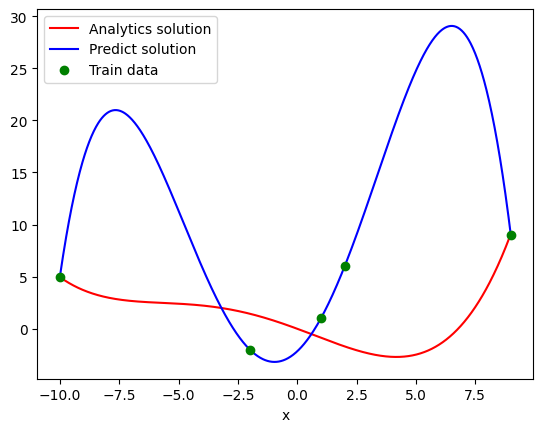

Method: RMSprop | LR : 0.01, LRS: Stepwise, Batch: 1 | Steps: 2500, Time (sec): 0.25701355934143066, Error: 2159390.8327883226 | Mem: (228466, 230146)
Regularization: WithoutRegularization


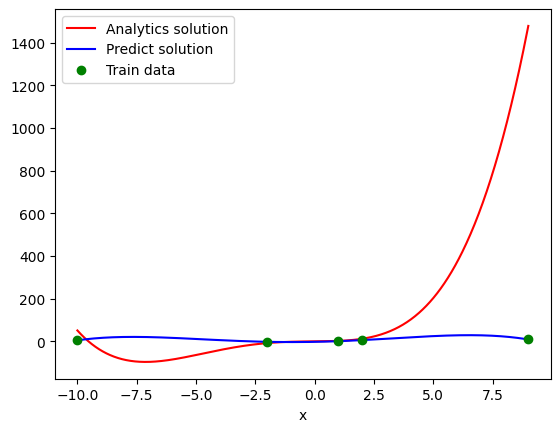

Method: RMSprop | LR : 0.01, LRS: Stepwise, Batch: 5 | Steps: 2500, Time (sec): 0.3958570957183838, Error: 23005606.995779447 | Mem: (228463, 230175)
Regularization: WithoutRegularization


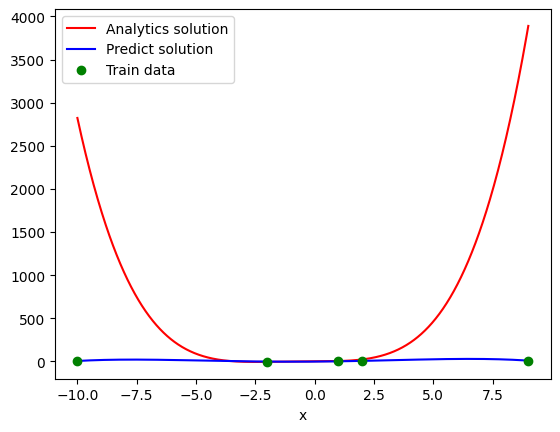

Method: Adam | LR : 0.01, LRS: Classic, Batch: 1 | Steps: 2500, Time (sec): 0.2749922275543213, Error: 52.750018370343255 | Mem: (80660, 82396)
Regularization: WithoutRegularization


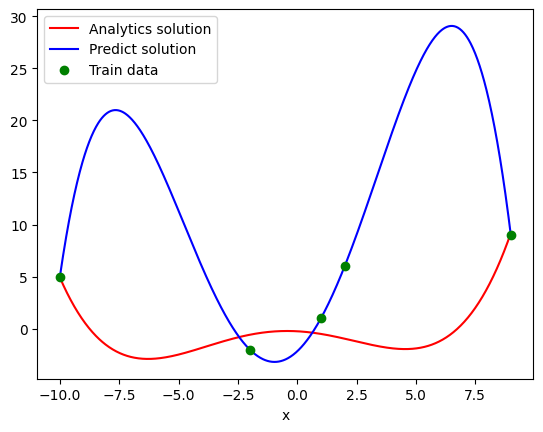

Method: Adam | LR : 0.01, LRS: Classic, Batch: 5 | Steps: 2500, Time (sec): 0.4200003147125244, Error: 69.18566131663692 | Mem: (228332, 230100)
Regularization: WithoutRegularization


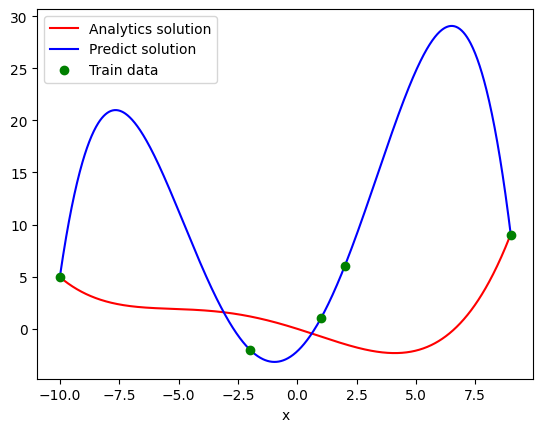

Method: Adam | LR : 0.01, LRS: Stepwise, Batch: 1 | Steps: 2500, Time (sec): 0.27399539947509766, Error: 2119071.692091852 | Mem: (228387, 230203)
Regularization: WithoutRegularization


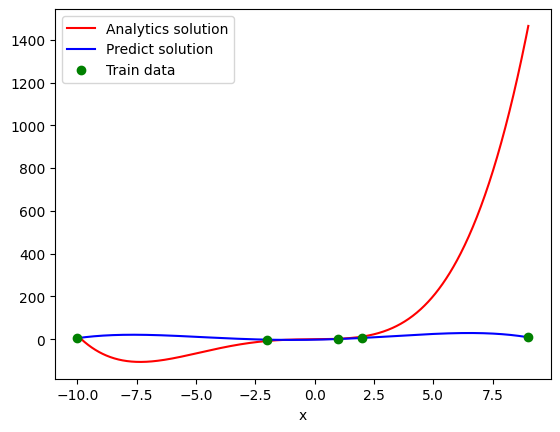

Method: Adam | LR : 0.01, LRS: Stepwise, Batch: 5 | Steps: 2500, Time (sec): 0.4306173324584961, Error: 23762063.807052337 | Mem: (228610, 230458)
Regularization: WithoutRegularization


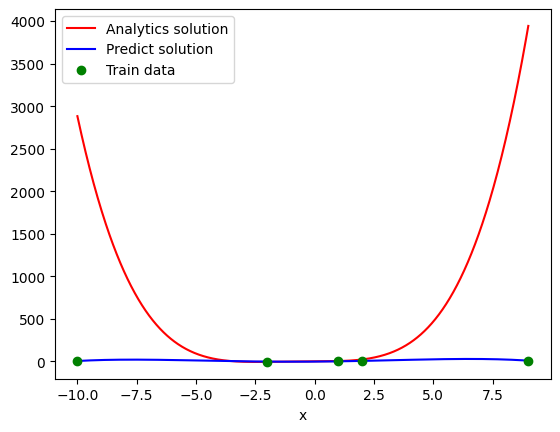

Method: Nesterov | LR : 0.01, LRS: Classic, Batch: 1 | Steps: 2500, Time (sec): 0.30999016761779785, Error: nan | Mem: (228227, 229691)
Regularization: WithoutRegularization


KeyboardInterrupt: 

In [163]:
import time
import tracemalloc

from excel import ExcellSaver


def poly_array(coeffs):
    return [lambda x, i=i: coeffs[i] * (x ** i) for i in range(len(coeffs))]


def poly(poly_arr):
    return lambda x: sum([poly_arr[i](x) for i in range(len(poly_arr))])


def generate_data(num_of_points, dimension, coeffs_left, coeffs_right, x_left, x_right, deviation, own_coeffs=None):
    coeffs = own_coeffs
    if coeffs == None:
        coeffs = np.array([float(random.randint(coeffs_left, coeffs_right)) for i in range(dimension + 1)])

    X = [random.uniform(x_left, x_right) for _ in range(num_of_points)]
    Y = [poly(poly_array(coeffs))(X[i]) + random.uniform(-deviation, +deviation) for i in range(num_of_points)]

    return [np.array(X), np.array(Y), coeffs]


def gen_linear_reg(dimension, num_of_points, coeffs_left, coeffs_right, x_left, x_right, deviation, own_coeffs=None):
    T = np.array(poly_array(np.ones(dimension + 1)))
    X, Y, coeffs = generate_data(num_of_points, dimension, coeffs_left, coeffs_right, x_left, x_right, deviation,
                                 own_coeffs)
    W = np.ones(len(coeffs))

    return LinearRegression(T, W, X, Y)


def test_universal(lin_reg, lr, method, lrs, batch=1, store_points=False):
    res_univ = {
        'mem': 0,
        'steps': 0,
        'time': 0,
        'error': 0
    }

    start = time.time()
    tracemalloc.start()
    steps = sgd_handler(lin_reg, lr, method, lrs=lrs, batch=batch, store_points=store_points)
    res_univ['mem'] = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end = time.time()

    res_univ['steps'] = steps
    res_univ['time'] = end - start
    res_univ['error'] = lin_reg.loss(lin_reg.W)

    return res_univ


def refresh_lin_reg(lin_reg, own_W=None):
    W = own_W
    if W is None:
        W = np.ones(len(lin_reg.W))

    lin_reg.W = np.copy(W)
    lin_reg.loss_values = [lin_reg.loss(lin_reg.W)]
    lin_reg.W_points = [np.copy(lin_reg.W)]


def show_info(method, step, lrs, batch, results):
    info = 'Method: {} | LR : {}, LRS: {}, Batch: {} | Steps: {}, Time (sec): {}, Error: {} | Mem: {}' \
        .format(method.name, step, lrs.name, batch, results['steps'], results['time'], results['error'], results['mem'])
    print(info)


def batch_test():
    print('-' * 50)
    print('Batch Test')

    num_of_points = 60
    lin_reg = gen_linear_reg(dimension=1, num_of_points=num_of_points,
                             coeffs_left=-2, coeffs_right=2, x_left=0., x_right=1., deviation=0.5)

    method = Methods.Classic
    step = 0.01
    lr = lambda *args: step
    lrs = LearningRateScheduling.Classic

    batch_res = [0]
    for batch in range(1, num_of_points + 1):
        refresh_lin_reg(lin_reg)
        results = test_universal(lin_reg, lr, method, lrs, batch)
        show_info(method, step, lrs, batch, results)
        batch_res.append(results['error'] / lin_reg.loss(lin_reg.analytical_solution()))
        if batch in [1, 2, 5, 10, num_of_points // 3, num_of_points]:
            visualise_points(lin_reg)

    visualise_batch_res(batch_res)


def lrs_test():
    print('-' * 50)
    print('LRS Test')

    num_of_points = 60
    method = Methods.Classic
    step = 0.01
    lr = lambda *args: step
    for lrs in LearningRateScheduling:
        for i in range(3):
            lin_reg = gen_linear_reg(dimension=1, num_of_points=num_of_points,
                                     coeffs_left=-2, coeffs_right=2, x_left=0., x_right=1., deviation=1.)

            refresh_lin_reg(lin_reg)
            results = test_universal(lin_reg, lr, method, lrs)
            show_info(method, step, lrs, results)
            visualise_points(lin_reg)


def methods_test():
    print('-' * 50)
    print('Method Test')

    num_of_points = 60
    step = 0.01
    lr = lambda *args: step
    lrs = LearningRateScheduling.Classic
    for method in Methods:
        for batch in [1, 5, num_of_points // 3, num_of_points]:
            for i in range(2):
                lin_reg = gen_linear_reg(dimension=1, num_of_points=num_of_points,
                                         coeffs_left=-2, coeffs_right=2, x_left=0., x_right=1., deviation=0.5)
                refresh_lin_reg(lin_reg)
                results = test_universal(lin_reg, lr, method, lrs, batch, store_points=False)
                show_info(method, step, lrs, batch, results)
                visualise_points(lin_reg)


def convergence_test():
    saver.add_new_sheet(['Method', 'LR', 'LRS', 'Batch', 'Error', 'Time (sec)', 'Mem'], 'Convergence Test')
    print('-' * 50)
    print('Convergence Test')

    num_of_points = 60
    lin_reg = gen_linear_reg(dimension=1, num_of_points=num_of_points,
                             coeffs_left=1, coeffs_right=2, x_left=1., x_right=2., deviation=0.5)
    step = 0.01
    lr = lambda *args: step
    for method in Methods:
        for lrs in LearningRateScheduling:
            for batch in [1, num_of_points // 3]:
                refresh_lin_reg(lin_reg)
                results = test_universal(lin_reg, lr, method, lrs, batch, store_points=True)
                saver.add_row([method.name, step, lrs.name, batch, results['error'], results['time'], results['mem']])
                show_info(method, step, lrs, batch, results)


def descent_trajectory_test():
    print('-' * 50)
    print('Descent Trajectory Test')

    num_of_points = 60
    lin_reg = gen_linear_reg(dimension=1, num_of_points=num_of_points,
                             coeffs_left=-2, coeffs_right=2, x_left=0., x_right=1., deviation=0.5)
    step = 0.01
    lr = lambda *args: step
    lrs = LearningRateScheduling.Classic
    for method in Methods:
        for batch in [1, num_of_points // 3, num_of_points]:
            refresh_lin_reg(lin_reg, own_W=np.array([-50., 10.]))
            results = test_universal(lin_reg, lr, method, lrs, batch, store_points=True)
            show_info(method, step, lrs, batch, results)
            last_point = lin_reg.W_points[-1]
            lin_reg.W_points = lin_reg.W_points[::num_of_points // batch]
            lin_reg.W_points.append(last_point)
            print(lin_reg.W_points[0])
            visualise_points(lin_reg)
            visualise_linear_sgd(lin_reg)


def poly_test():
    print('-' * 50)
    print('Poly Test')

    num_of_points = 60
    step = 0.01
    lr = lambda *args: step
    lrs = LearningRateScheduling.Classic
    for method in Methods:
        for batch in [1, num_of_points // 3, num_of_points]:
            for dimension in [2, 5, 8]:
                lin_reg = gen_linear_reg(dimension=dimension, num_of_points=num_of_points,
                                         coeffs_left=-2, coeffs_right=2, x_left=0., x_right=1., deviation=0.5)
                results = test_universal(lin_reg, lr, method, lrs, batch)
                show_info(method, step, lrs, batch, results)
                visualise_points(lin_reg)


def regul_test():
    print('-' * 50)
    print('Regul Test')

    num_of_points = 5
    step = 0.01
    lr = lambda *args: step
    t = poly_array(np.ones(num_of_points))
    w = np.ones(num_of_points)
    x = np.array([1., 2., 9., -2., -10.])
    y = np.array([1., 6., 9., -2., 5])
    lin_reg = LinearRegression(t, w, x, y)

    for regularization in Regularization:
        for method in Methods:
            for lrs in LearningRateScheduling:
                if lrs == LearningRateScheduling.Exponential:
                    continue
                for batch in [1, 5]:
                    refresh_lin_reg(lin_reg)
                    lin_reg.regularization = regularization
                    results = test_universal(lin_reg, lr, method, lrs, batch)
                    show_info(method, step, lrs, batch, results)
                    print('Regularization: {}'.format(regularization.name))
                    visualise_points(lin_reg)


saver = ExcellSaver()

# batch_test()
# lrs_test()
# methods_test()
# convergence_test()
# descent_trajectory_test()
# poly_test()
regul_test()
# saver.create_excel()
